In [3]:
from pathlib import *
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import shutil

In [2]:
def find_files_with_terms(dir_path='Dataset/Texts', annotation='Dataset/Terms/_all_annotation_map_to_acl_arc_id.txt'):
    """
    Finding files that have terms and removing files that have less than 20 valid terms
            Parameters:
                    dir_path (str): directory with documents sorted by year into the appropriate directories
                    annotation (str): name of the file with annotations
            Return:
                    statistics (list): list of the number of terms in documents
                    save_files (list): list of names of selected files
    """
    # Finding files that have terms
    files = []
    with open(annotation) as fin:
        for i in re.finditer(r'^[A-Z][0-9]{2}-[0-9]{4}', fin.read(), re.M):
            files.append(i.group(0))

    # Removing files that have less than 20 valid terms
    statistics = []
    save_files = []
    dict_files = dict(Counter(files))
    for k in dict_files.keys():
        if dict_files[k] > 20:
            save_files.append(k)
            statistics.append(dict_files[k])

    # Deleting unnecessary files
    for direct in Path(dir_path).iterdir():
        number = direct.stem
        new_path = Path(dir_path + '/' + number)
        for item in Path(new_path).iterdir():
            if item.stem not in save_files:
                item.unlink()
    return save_files, statistics

In [3]:
save_files, statistics = find_files_with_terms()

In [8]:
def plot_statistics(statistics, name, bins=60):
    """
    Builds a histogram with the number of terms in the documents and saves it to a file in eps format
            Parameters:
                    statistics (list): list of the number of terms in documents
                    name (str): the name of the file to save the histogram in the 'eps' format
                    bins (int): number of bins
    """
    plt.rcParams["font.family"] = "Times New Roman"
    plt.hist(statistics, bins=bins)
    plt.xlabel('Количество терминов', fontsize=14)
    plt.ylabel('Количество документов', fontsize=14)
    plt.savefig(name, format='eps', bbox_inches='tight')

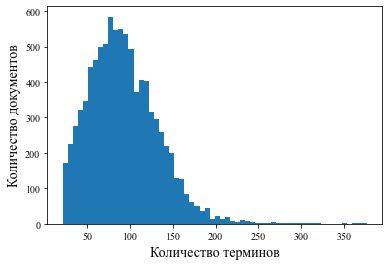

In [9]:
plot_statistics(statistics, 'Dataset/Statistics.eps')

In [21]:
def create_markup(save_files, json_name='Dataset/Terms/Marks.json', \
                  annotation='Dataset/Terms/_all_annotation_map_to_acl_arc_id.txt', \
                  valid_terms = 'Dataset/Terms/valid_terms.txt'):
    """
    Saves the markup file in json format
            Parameters:
                    save_files (list): list of names of selected files
                    json_name (str): The name of the file to save in 'json' format
                    annotation (str): name of the file with annotations
                    valid_terms (str): name of the file with valid terms
    """
    previous_file = 'A00-1005'
    words = []
    marks = {}
    count = 0

    with open(annotation, 'r') as fin:
        for line in fin.readlines():
            if line[0:8] != previous_file:
                # Progress
                if count % 500 == 0:
                    print('Processed: ', count)
                count += 1
                
                marks[previous_file] = words
                words = []
                previous_file = line[0:8]
            if line[0:8] in save_files:
                with open(valid_terms, 'r') as terms:
                    for term in terms.readlines():
                        if line.split()[1] == term.split()[0]:
                            split_terms = term.split()[1:-1]
                            words.append(' '.join(split_terms))
                            break

            marks[line[0:8]] = words

    with open(json_name, 'w') as fp:
        json.dump(marks, fp)

In [22]:
create_markup(save_files)

Processed:  0
Processed:  500
Processed:  1000
Processed:  1500
Processed:  2000
Processed:  2500
Processed:  3000
Processed:  3500
Processed:  4000
Processed:  4500
Processed:  5000
Processed:  5500
Processed:  6000
Processed:  6500
Processed:  7000
Processed:  7500
Processed:  8000
Processed:  8500
Processed:  9000
Processed:  9500


In [23]:
def find_1_term_files(json_name='Dataset/Terms/Marks.json', json_name_save='Dataset/Terms/Marks_1.json'):
    """
    Collects statistics on terms from a single word and save the markup file in json format
            Parameters:
                    json_name (str): The name of the file to load markup in 'json' format
                    json_name_save (str): The name of the file to save in 'json' format
            Return:
                    statistics (list): list of the number of 1-word-terms in documents
    """
    with open(json_name, 'r') as fp:
        data = json.load(fp)
    data_1 = {}
    statistics = []

    for k in data.keys():
        data_1[k] = []
        for term in data[k]:
            if len(term.split()) == 1:
                data_1[k].append(term)
        if not data_1[k]:
            del data_1[k]
        else:
            statistics.append(len(data_1[k]))
            
    with open(json_name_save, 'w') as fp:
        json.dump(data_1, fp)
    return statistics

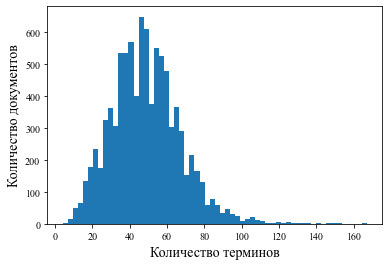

In [25]:
term_1_statistics = find_1_term_files()
plot_statistics(term_1_statistics, 'Dataset/Statistics_1.eps')

In [15]:
def cutting_info(input_path='Dataset/Texts', output_path='Dataset/Texts_cut'):
    """
    Deleting the title, authors and references
            Parameters:
                    input_path (str): directory with documents sorted by year to load
                    output_path (str): directory with documents sorted by year to save
            Return:
                    statistics (list): list of the number of 1-word-terms in documents
    """
    for direct in Path(input_path).iterdir():
        number = direct.stem
        new_input_path = Path(input_path + '/' + number)

        for item in Path(new_input_path).iterdir():
            new_output_path = Path(output_path + '/' + number + '/' + item.name)
            fout = open(new_output_path, 'w')
            f = 0

            with open(item, 'r', errors="ignore") as fin:
                for line in fin.readlines():
                    if 'Abstract' in line or 'ABSTRACT' in line:
                        f = 1
                    elif 'References' in line or 'REFERENCES' in line:
                        if f == 0:
                            f = 3
                        else:
                            f = 2
                    if f == 1:
                        fout.write(line)
                if f == 0:
                    shutil.copy(item, new_output_path)

            if f == 3:
                with open(item, 'r', errors="ignore") as fin:
                    for line in fin.readlines():
                        fout.write(line)
                        if 'References' in line or 'REFERENCES' in line:
                            break

            fout.close()

In [ ]:
cutting_info()

In [26]:
def train_test(json_name='Dataset/Terms/Marks_1.json', input_dir='Dataset/Texts_cut/', \
               vw_train='Dataset/Train_test/Train/Train_1.vw.txt', \
               vw_test='Dataset/Train_test/Test/Test_1.vw.txt', train_json='Dataset/Train_test/Train_1.json', \
               test_json='Dataset/Train_test/Test_1.json'):
    """
    Splitting documents into train and test, saving documents in vowpal_wabbit format and markup in json format
            Parameters:
                    json_name (str): the name of the file to load markup in 'json' format
                    input_dir (str): directory with documents sorted by year into the appropriate directories
                    vw_train (str): the name of the file to save train texts in Vowpal Wabbit format
                    vw_test (str): the name of the file to save test texts in Vowpal Wabbit format
                    train_json (str): the name of the file to save train murkup in 'json' format
                    text_json (str): the name of the file to save test murkup in 'json' format
    """
    with open(json_name, 'r') as fp:
        data = json.load(fp)
    vw_train_output = open(vw_train, 'w')
    vw_test_output = open(vw_test, 'w')
    count = 0
    count_train = 0
    count_test = 0
    data_train = {}
    data_test = {}
    
    # bad files
    del data['C00-1038']
    del data['C98-1083']
    del data['C98-1092']
    del data['C98-1117']
    del data['E97-1035']

    for k in data.keys():
        number = k[1:3]
        input_path = input_dir + number + '/' + k + '.txt'
        with open(input_path, 'r', errors="ignore") as fin:
            words = fin.read()
            # removing numbers from text
            words = re.sub(r'[^\w\s]+|[\d]+', r'', words).strip()
            
            # 10% for test
            if count % 10 == 9:
                data_test[k] = data[k]
                vw_test_output.write('doc_{} {}\n'.format(count_test, words))
                count_test += 1
            else:
                data_train[k] = data[k]
                vw_train_output.write('doc_{} {}\n'.format(count_train, words))
                count_train += 1
        count += 1

    vw_train_output.close()
    vw_test_output.close()

    with open(train_json, 'w') as fp:
        json.dump(data_train, fp)

    with open(test_json, 'w') as fp:
        json.dump(data_test, fp)

In [27]:
train_test()

In [22]:
def NER_preprocess(input_path='Dataset/Texts', output_path='Dataset/Texts_NER_1', json_name='Dataset/Terms/Marks_1.json'):
    """
    Text markup and preprocess for neural network BERT
            Parameters:
                    input_path (str): directory with documents sorted by year to load
                    output_path (str): directory with documents sorted by year to save
                    json_name (str): name of the file with markup in 'json format'
    """
    with open(json_name, 'r') as fp:
        data = json.load(fp)

    count = 0
    for direct in Path(input_path).iterdir():
        number = direct.stem
        new_input_path = Path(input_path + '/' + number)
   
        for item in Path(new_input_path).iterdir():
            new_output_path = Path(output_path + '/' + number + '/' + item.name)
            fout = open(new_output_path, 'w')

            with open(item, 'r', errors="ignore") as fin:
                line_num = 0
                for line in fin.readlines():
                    # removing numbers from text
                    line = re.sub(r'[^\w\s]+|[\d]+', r'',line).strip()
                    words = line.split()
                    
                    # deleting words whose length is less than 3 and assigning markup 'B' for terms and 'O' for regular words
                    for word in words:
                        if len(word) > 2:
                            if word.lower() in data[item.stem]:
                                fout.write(str(line_num) + ' ' + word.lower() + ' ' + 'B\n')
                            else:
                                fout.write(str(line_num) + ' ' + word.lower() + ' ' + 'O\n')
                    line_num += 1
                if count % 1000 == 0:
                    print('Progress: ', count)
                count += 1
            fout.close()

In [23]:
NER_preprocess()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
